In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


METHOD 2

In [ ]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings("ignore")
from sklearn.metrics import roc_auc_score, roc_curve,auc,precision_recall_curve
from sklearn.model_selection import GridSearchCV, KFold, cross_val_score
from sklearn.model_selection import train_test_split
import xgboost as xgb
import matplotlib.pyplot as plt
np.random.seed(42)

In [ ]:
PATH = '/content/gdrive/MyDrive/PDA'

df_test = pd.read_csv(PATH + '/test_simulated.csv')
df_test.drop(['ID_code'], axis=1, inplace=True)
df_test = df_test.values

unique_samples = []
unique_count = np.zeros_like(df_test)
for feature in range(df_test.shape[1]):
    _, index_, count_ = np.unique(df_test[:, feature], return_counts=True, return_index=True)
    unique_count[index_[count_ == 1], feature] += 1

# Samples which have unique values are real the others are fake
real_samples_indexes = np.argwhere(np.sum(unique_count, axis=1) > 0)[:, 0]
synthetic_samples_indexes = np.argwhere(np.sum(unique_count, axis=1) == 0)[:, 0]

print('Found',len(real_samples_indexes),'real test')
print('Found',len(synthetic_samples_indexes),'fake test')


d = {}
for i in range(200): d['var_'+str(i)] = 'float32'
d['target'] = 'uint8'
d['ID_code'] = 'object'

Found 40000 real test
Found 0 fake test


In [ ]:
# simple variance transform

train_2 = pd.read_csv(PATH + '/train_simulated.csv')
test_2 = pd.read_csv(PATH + '/test_simulated.csv')

ids = np.arange(test_2.shape[0])
real_ids = list(set(ids) - set(synthetic_samples_indexes))
real_test = test_2.iloc[real_ids]
fake_test = test_2.iloc[synthetic_samples_indexes]
real_test_id = real_test.ID_code
features = [c for c in train_2.columns if c not in ['target', 'ID_code']]
df = pd.concat([train_2,real_test], axis = 0)

# FE
for feat in features:
    df[feat+'_var'] = df.groupby([feat])[feat].transform('var')
    df[feat+'plus_'] = df[feat] + df[feat+'_var']
    #df[feat+"minus"] = df[feat] - df[feat+'_var']
    
drop_features = [c for c in df.columns if '_var' in c]
df.drop(drop_features, axis=1, inplace=True)

In [ ]:
train = df.iloc[:train_2.shape[0]]
real_test = df.iloc[train_2.shape[0]:]

features = [c for c in train.columns if c not in ['ID_code', 'target']]
target = train['target'] 

print(train.shape)
print(real_test.shape)
print(len(features))

(160000, 402)
(40000, 402)
400


In [ ]:
# shuffle func
def disarrange(a, axis=-1):
    """
    Shuffle `a` in-place along the given axis.
    Apply numpy.random.shuffle to the given axis of `a`.
    Each one-dimensional slice is shuffled independently.
    """
    b = a.swapaxes(axis, -1)
    # Shuffle `b` in-place along the last axis.  `b` is a view of `a`,
    # so `a` is shuffled in place, too.
    shp = b.shape[:-1]
    for ndx in np.ndindex(shp):
        np.random.shuffle(b[ndx])
    return

def augment_fast2(x,y,t=2):
    xs,xn = [],[]
    for i in range(t):
        mask = y>0
        x1 = x[mask].copy()
        disarrange(x1,axis=0)
        xs.append(x1)

    for i in range(t//2):
        mask = y==0
        x1 = x[mask].copy()
        disarrange(x1,axis=0)
        xn.append(x1)

    xs = np.vstack(xs)
    xn = np.vstack(xn)
    ys = np.ones(xs.shape[0])
    yn = np.zeros(xn.shape[0])
    x = np.vstack([x,xs,xn])
    y = np.concatenate([y,ys,yn])
    return x,y

In [ ]:
x = train[features]
y = train['target']
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2)

X_t, y_t = augment_fast2(x_train.values, y_train.values)
X_t = pd.DataFrame(X_t)
X_t = X_t.add_prefix('var_')

In [ ]:
x_test.columns = X_t.columns

In [ ]:
param = {}
param['booster'] = 'gbtree'
param['max_depth'] = 5
param['n_estimators'] = 180
param['learning_rate'] = 0.25
param['objective'] = 'binary:logitraw'
param['eval_metric'] = 'auc'
param['silent'] = 1
param['tree_method'] = 'gpu_hist'
gpu_res = {}

In [ ]:
dtrain = xgb.DMatrix(data=X_t, label=y_t)
dtest = xgb.DMatrix(data=x_test, label=y_test)
xgbClf = xgb.train(param, dtrain, num_boost_round=100000, 
                   early_stopping_rounds=3000, evals=[(dtest, 'eval')], 
                   evals_result=gpu_res,
                   verbose_eval = 1000)

[0]	eval-auc:0.596458
Will train until eval-auc hasn't improved in 3000 rounds.
[1000]	eval-auc:0.902661
[2000]	eval-auc:0.905128
[3000]	eval-auc:0.905652
[4000]	eval-auc:0.906092
[5000]	eval-auc:0.906748
[6000]	eval-auc:0.906953
[7000]	eval-auc:0.907189
[8000]	eval-auc:0.907268
[9000]	eval-auc:0.907304
[10000]	eval-auc:0.907353
[11000]	eval-auc:0.907435
[12000]	eval-auc:0.907424
[13000]	eval-auc:0.907415
[14000]	eval-auc:0.907422
[15000]	eval-auc:0.907339
Stopping. Best iteration:
[12292]	eval-auc:0.907487



## Misclassification Cost

In [ ]:
df_test = pd.read_csv(PATH + '/test_simulated.csv')

In [ ]:
def Evaluation(model,test_X,test_Y,fp_cost,fn_cost):
    prob=model.predict(test_X)
    fpr,tpr,threshold=roc_curve(test_Y,prob)
    roc_auc=auc(fpr,tpr)
    results=pd.DataFrame({'Actual_Value':list(test_Y),'Probability':list(prob)}).sort_values('Probability',ascending=False)
    results['num']=np.arange(len(test_Y))+1
    results['pct']=(np.arange(len(test_Y))+1)/len(test_Y)
    results['threshold']= results['num']/len(test_Y)
    results['TP'] = results['Actual_Value'].cumsum()
    results['FP'] = results['num']-results['TP']
    results['TN']= (len(test_Y) - results['num'])-(sum(results['Actual_Value'])-results['TP'])
    results['FN']= sum(results['Actual_Value'])-results['TP']
    results['tpr']= results['TP']/sum(results['Actual_Value'])
    results['fpr']= results['FP']/(len(test_Y)-sum(results['Actual_Value']))
    results['precision']=results['TP']/results['num']
    results['recall']=results['TP']/(results['TP']+results['FN'])
    results['f']=2*results['precision']*results['recall']/(results['recall']+results['precision'])
    results['lift']=results['precision']/(sum(results['Actual_Value'])/len(test_Y))
    results['accuracy']=(results['TP']+results['TN'])/len(test_Y)
    results['fp_cost']=results['FP']*fp_cost
    results['fn_cost']=results['FN']*fn_cost
    results['total_cost']=(results['fp_cost']+results['fn_cost'])/len(test_Y)
    df=results[results['total_cost']==results['total_cost'].min()][['threshold','accuracy','precision','recall','f','total_cost']]
    print(df.iloc[0,:])
    #Plot ROC Curve
    plt.figure(figsize=[10,5])
    plt.plot(results['threshold'],results['total_cost'],'g--')
    plt.title('Cost Curve',fontsize=30)
    plt.show() 
    df_2 = results[results['total_cost']==results['total_cost'].min()]
    return df_2.iloc[0,:]


According to a survey conducted by Parvathy P (2017), it costs a bank around 80 USD to acquire a credict card customer who returns about 120 USD in profit.  
We will use 80 as false positive cost (Cost of mis-classifying a customer that will never make a transaction as a potential customer)
We will use 120 as false negative cost (Cost of mis-classifying a potential customer)


In [ ]:
test_3 = real_test.drop(['ID_code', "target"], axis=1)
test_y = real_test['target']
test_3.columns = X_t.columns
test_3 = xgb.DMatrix(data=test_3, label=test_y)

threshold     0.067400
accuracy      0.926625
precision     0.715504
recall        0.470832
f             0.567938
total_cost    8.038000
Name: 10724, dtype: float64


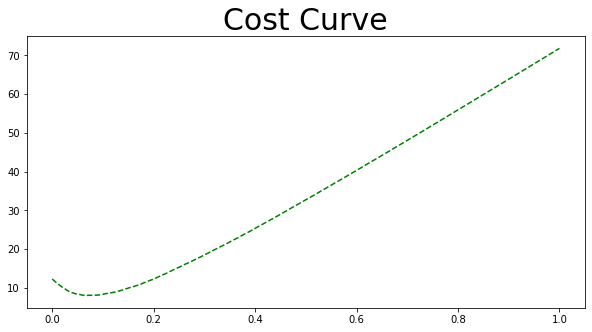

Actual_Value         1.000000
Probability         -0.319201
num               2696.000000
pct                  0.067400
threshold            0.067400
TP                1929.000000
FP                 767.000000
TN               35136.000000
FN                2168.000000
tpr                  0.470832
fpr                  0.021363
precision            0.715504
recall               0.470832
f                    0.567938
lift                 6.985643
accuracy             0.926625
fp_cost          61360.000000
fn_cost         260160.000000
total_cost           8.038000
Name: 10724, dtype: float64

In [ ]:
fp_cost = 80
fn_cost = 120
Evaluation(xgbClf,test_3,test_y.values,fp_cost,fn_cost)

In [ ]:
def Evaluation(model,test_X,test_Y,fp_cost,fn_cost):
    prob=model.predict(test_X)
    fpr,tpr,threshold=roc_curve(test_Y,prob)
    roc_auc=auc(fpr,tpr)
    results=pd.DataFrame({'Actual_Value':list(test_Y),'Probability':list(prob)}).sort_values('Probability',ascending=False)
    results['num']=np.arange(len(test_Y))+1
    results['pct']=(np.arange(len(test_Y))+1)/len(test_Y)
    results['threshold']= results['num']/len(test_Y)
    results['TP'] = results['Actual_Value'].cumsum()
    results['FP'] = results['num']-results['TP']
    results['TN']= (len(test_Y) - results['num'])-(sum(results['Actual_Value'])-results['TP'])
    results['FN']= sum(results['Actual_Value'])-results['TP']
    results['tpr']= results['TP']/sum(results['Actual_Value'])
    results['fpr']= results['FP']/(len(test_Y)-sum(results['Actual_Value']))
    results['precision']=results['TP']/results['num']
    results['recall']=results['TP']/(results['TP']+results['FN'])
    results['f']=2*results['precision']*results['recall']/(results['recall']+results['precision'])
    results['lift']=results['precision']/(sum(results['Actual_Value'])/len(test_Y))
    results['accuracy']=(results['TP']+results['TN'])/len(test_Y)
    results['fp_cost']=results['FP']*fp_cost
    results['fn_cost']=results['FN']*fn_cost
    results['total_cost']=(results['fp_cost']+results['fn_cost'])/len(test_Y)
    df=results[results['total_cost']==results['total_cost'].min()][['threshold','accuracy','precision','recall','f','total_cost']]
    print(df.iloc[0,:])
    #Plot ROC Curve
    plt.figure(figsize=[19,5])
    plt.subplot(1,2,1)
    plt.plot(results['fpr'],results['tpr'],'r--',label=['ROC(AUC = %0.2f)'%roc_auc])
    plt.legend()
    plt.title('ROC Curve',fontsize=30)
    plt.subplot(1,2,2)
    plt.plot(results['pct'],results['lift'],'b--')
    plt.title('Lift Curve',fontsize=30)
    plt.show() 
    df_2 = results[results['total_cost']==results['total_cost'].min()]
    return df_2.iloc[0,:]

threshold     0.067400
accuracy      0.926625
precision     0.715504
recall        0.470832
f             0.567938
total_cost    8.038000
Name: 10724, dtype: float64


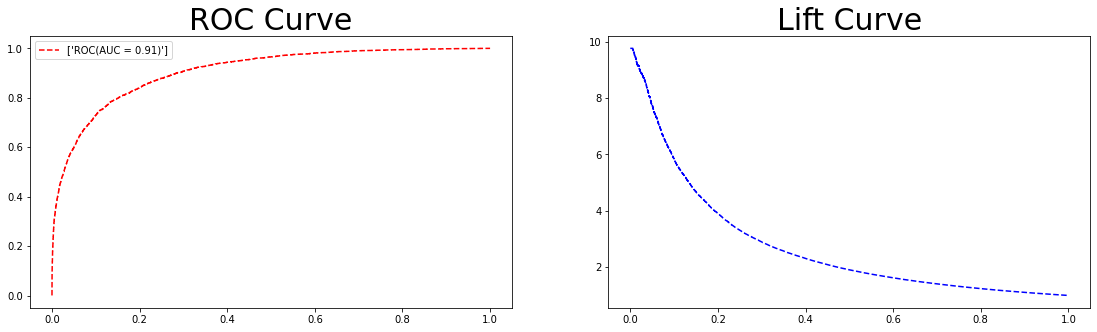

Actual_Value         1.000000
Probability         -0.319201
num               2696.000000
pct                  0.067400
threshold            0.067400
TP                1929.000000
FP                 767.000000
TN               35136.000000
FN                2168.000000
tpr                  0.470832
fpr                  0.021363
precision            0.715504
recall               0.470832
f                    0.567938
lift                 6.985643
accuracy             0.926625
fp_cost          61360.000000
fn_cost         260160.000000
total_cost           8.038000
Name: 10724, dtype: float64

In [ ]:
test_y = df_test['target']
fp_cost = 80
fn_cost = 120
Evaluation(xgbClf,test_3,test_y.values,fp_cost,fn_cost)